In [ ]:
pip install pwlf

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pwlf: filename=pwlf-2.3.0-py3-none-any.whl size=16651 sha256=f24a6a98fa999ef305bb2352077524ef9dac49fd43d22ca67a0f7b875310734b
  Stored in directory: /root/.cache/pip/wheels/83/da/81/eb904e6d4045d0fd6922019cae45e52e83e475a06df5e7f9ae
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=68f76ae4f06aed0d2cebc6735aa00065ca1027f86ed2bc877c06566799addd13
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pwlf pyDOE


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import pwlf
from scipy import stats
from google.colab import files
import matplotlib.pyplot as plt

In [ ]:
def generate_fourier_ic(x, n_modes=5, seed=None):
    """TODO: Generate random Fourier series initial condition.
    Hints:
    1. Use random coefficients for sin and cos terms
    2. Ensure the result is normalized to [-1, 1]
    3. Consider using np.random.normal for coefficients
    """
    if seed is not None:
        np.random.seed(seed)

    # TODO: Generate coefficients for Fourier series
    coeff=np.random.normal(0,10,2*n_modes+1)
    p=np.random.randint(2,5) #number of periods
    # TODO: Compute the Fourier series
    y=np.zeros(x.shape)
    for j in range(x.shape[0]): # for every grid point
      for i in range(n_modes):  #weighted sum of the coefficient times sines and cosines
        y[j]+=coeff[i]*np.sin(np.pi*p*x[j]*(i+1))+coeff[n_modes+i]*np.cos(np.pi*p*x[j]*(i+1))
    y+=coeff[2*n_modes]
    # TODO: Normalize to [-1, 1]
    m=np.max(np.abs(y))+np.random.randint(0,10) #10% chance to touch -1,1
    y/=m
    return y


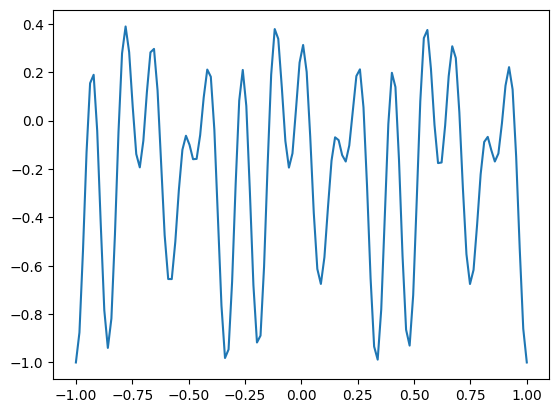

In [ ]:
x=np.linspace(-1,1,128)
y=generate_fourier_ic(x)
plt.plot(x,y)

In [ ]:
def generate_gmm_ic(x, n_components=None, seed=None):
    """TODO: Generate Gaussian mixture model initial condition.
    Hints:
    1. Random number of components if n_components is None
    2. Use random means, variances, and weights
    3. Ensure result is normalized to [-1, 1]
    """
    if seed is not None:
        np.random.seed(seed)

    if n_components is None:
        n_components = np.random.randint(2, 6)

    # TODO: Generate means, variances, and weights
    means=np.zeros(n_components)
    for i in range(n_components):
        means[i]=np.random.normal(((-1)**i)*i/2,(i+1))

    variances=np.zeros(n_components)
    for i in range(n_components):
      variances[i]=np.random.uniform(0.1, (i+1))#random variances taken from a uniform distr (to ensure positiveness)
    weights=np.random.uniform(-2,2,n_components)

    y_grid=np.zeros(x.shape)
    # TODO: Compute GMM
    for i in range(x.shape[0]):
        for j in range(n_components):
            y_grid[i]+=weights[j]*stats.norm.pdf(x[i],loc=means[j],scale=variances[j])*np.sqrt(2*np.pi*variances[j])
    # TODO: Normalize to [-1, 1]
    m=np.max(np.abs(y_grid))+np.random.randint(0,10)/20
    y_grid/=m
    return y_grid

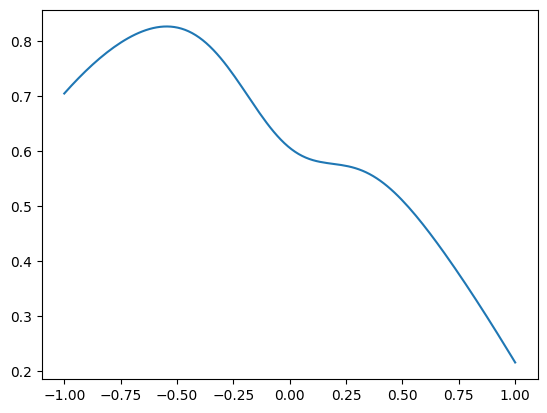

In [ ]:
y=generate_gmm_ic(x)

plt.plot(x,y)

In [ ]:
def generate_piecewise_ic(x, n_pieces=None, seed=None):
    """TODO: Generate piecewise linear initial condition.
    Hints:
    1. Generate random breakpoints
    2. Create piecewise linear function
    3. Add occasional discontinuities
    """
    if seed is not None:
        np.random.seed(seed)

    if n_pieces is None:
        n_pieces = np.random.randint(3, 7) #return uniformly at random a number between 3,4,5,6

    # TODO: Generate breakpoints
    break_points=np.random.uniform(-1,1,n_pieces)
    y_grid=np.zeros(n_pieces)
    # TODO: Generate values at breakpoints
    for i in range(n_pieces):
        y_grid[i]=np.random.standard_normal() #generate values at those points


    # TODO: Create piecewise linear function
    model=pwlf.PiecewiseLinFit(break_points,y_grid,seed=seed)
    model.fit_with_breaks(break_points)
    y=model.predict(x)
    m=np.max(np.abs(y))+np.random.randint(0,10)/10
    y/=m
    return y

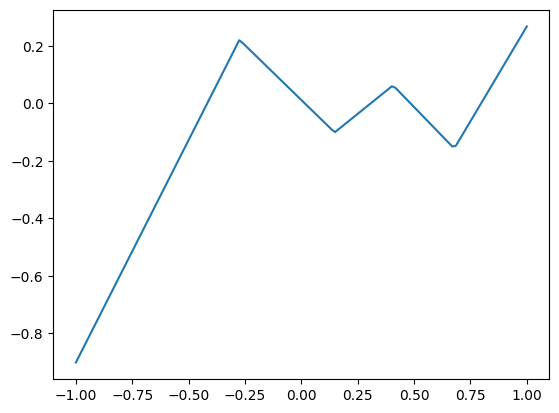

In [ ]:
y=generate_piecewise_ic(x)
plt.plot(x,y)

In [ ]:
def allen_cahn_rhs(t, u, epsilon, x_grid):
    """TODO: Implement Allen-Cahn equation RHS:
        ∂u/∂t = Δu - (1/ε²)(u³ - u)
    """
    dx = x_grid[1] - x_grid[0]
    n = x_grid.shape[0]
    # TODO: Compute Laplacian (Δu) with periodic boundary conditions
    laplacian=np.zeros(n)
    laplacian[0] = (2*u[0] - 5*u[1] + 4*u[2] - u[3]) / dx**2
    laplacian[n-1] = (2*u[n-1] - 5*u[n-2] + 4*u[n-3] - u[n-4]) / dx**2
    for i in range(1,n-1):
        laplacian[i]=(u[i+1]-2*u[i]+u[i-1])/(dx**2)
    # TODO: Compute nonlinear term -(1/ε²)(u³ - u)
    nonlin=-1/(epsilon**2)*(u**3-u)
    # TODO: Return full RHS
    return laplacian+nonlin

def generate_dataset(n_samples, epsilon, x_grid, t_eval, ic_type='fourier', seed=None):
    """Generate dataset for Allen-Cahn equation."""
    if seed is not None:
        np.random.seed(seed)

    # Initialize dataset array
    dataset = np.zeros((n_samples, len(t_eval), len(x_grid)))

    # Generate samples
    for i in range(n_samples):
        # Generate initial condition based on type
        if ic_type == 'fourier':
            u0 = generate_fourier_ic(x_grid, seed=seed+i if seed else None)
        elif ic_type == 'gmm':
            u0 = generate_gmm_ic(x_grid, seed=seed+i if seed else None)
        elif ic_type == 'piecewise':
            u0 = generate_piecewise_ic(x_grid, seed=seed+i if seed else None)
        else:
            raise ValueError(f"Unknown IC type: {ic_type}")

        # Solve PDE using solve_ivp
        sol = solve_ivp(
            allen_cahn_rhs,
            t_span=(t_eval[0], t_eval[-1]),
            y0=u0,
            t_eval=t_eval,
            args=(epsilon, x_grid),
            method='RK45',
            rtol=1e-6,
            atol=1e-6
        )

        dataset[i] = sol.y.T

    return dataset

In [ ]:
nx = 128
x_grid = np.linspace(-1, 1, nx)

    # Set up temporal grid
t_eval = np.array([0.0, 0.25, 0.50, 0.75, 1.0])/100

    # Parameters for datasets
epsilons = [0.1, 0.075, 0.04, 0.032]  # Different epsilon values
n_train = 800  # Number of training samples per configuration
n_test = 200    # Number of test samples
base_seed = 42  # For reproducibility
ic_type=["fourier", "gmm", "piecewise"]
print(t_eval)

[0.     0.0025 0.005  0.0075 0.01  ]


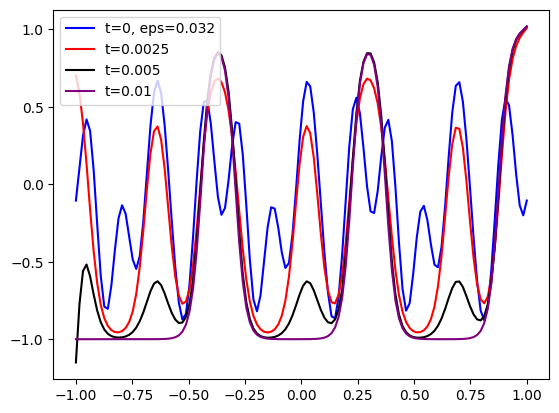

In [ ]:
l=generate_dataset(1,0.032,x_grid,t_eval,seed=42)
plt.plot(x_grid,l[0,0,:], color='blue',label='t=0, eps=0.032')
plt.plot(x_grid,l[0,1,:], color='red', label='t=0.0025')
plt.plot(x_grid,l[0,2,:], color='black',label='t=0.005')
#plt.plot(x_grid,l[0,3,:], color='green',label='t=0.0075')
plt.plot(x_grid,l[0,4,:], color= 'purple',label='t=0.01')
plt.legend()

In [ ]:
training_datasets={i: np.zeros((n_train*len(ic_type), len(t_eval), len(x_grid))) for i in epsilons} #every eps has n_train*3 trajectories
q=0
for i in epsilons:
    for j in ic_type:
        training_datasets[i][(n_train*q):(n_train*(q+1)),:,:]=generate_dataset(n_train, i, x_grid, t_eval,j,base_seed) #maps eps to its traj coming from all ic types
        q+=1
    q=0

np.save("training_datasets_100.npy",training_datasets)
files.download("training_datasets_100.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
testing_datasets={i: np.zeros((n_test*len(ic_type), len(t_eval), len(x_grid))) for i in epsilons} #every eps has n_train*3 trajectories
q=0
for i in epsilons:
    for j in ic_type:
        testing_datasets[i][(n_test*q):(n_test*(q+1)),:,:]=generate_dataset(n_test, i, x_grid, t_eval,j,10000) #maps eps to its traj coming from all ic types
        q+=1
    q=0
    # TODO: Generate OOD test datasets (high frequency, sharp transitions)

np.save('testing_datasets_100.npy',testing_datasets)
files.download("testing_datasets_100.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def high_frequency_ic(x, seed=None):

    if seed is not None:
        np.random.seed(seed)

    amplitudes=np.random.uniform(0.01,1)
    frequencies=np.random.randint(10,20)
    y=amplitudes*np.sin(np.pi*frequencies*x)

    return y

In [ ]:
def exponential_decay(x, seed=None):

    if seed is not None:
        np.random.seed(seed)
    freq=np.random.randint(15,20)
    y=np.exp(-3*x)*np.sin(x*np.pi*freq)
    m=np.max(y)+np.random.randint(0,10)
    y/=m
    if np.random.randint(0,2)%2==0: #50% in the other direction
        y=np.flip(y)
    return y

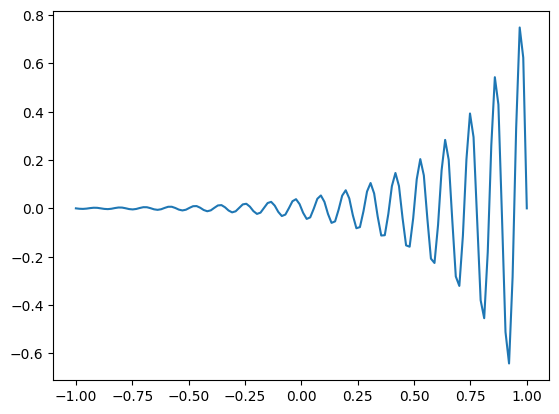

In [ ]:
y=exponential_decay(x)
plt.plot(x,y)

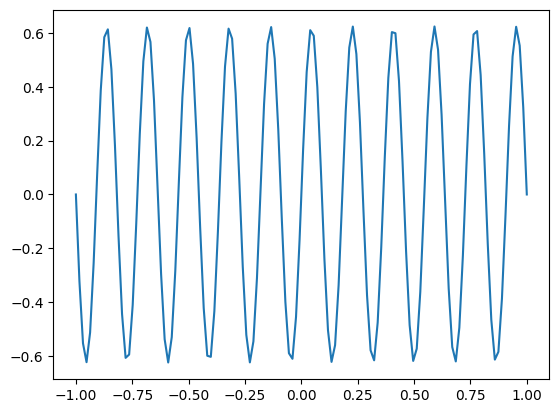

In [ ]:
y = high_frequency_ic(x)
plt.plot(x,y)

In [ ]:
def generate_dataset_ood(n_samples, epsilon, x_grid, t_eval, ic_type='ood', seed=None):
    """Generate dataset for Allen-Cahn equation."""
    if seed is not None:
        np.random.seed(seed)

    # Initialize dataset array
    dataset = np.zeros((n_samples, len(t_eval), len(x_grid)))

    # Generate samples
    for i in range(n_samples):
        # Generate initial condition based on type
        if ic_type=='ood':
            u0 = high_frequency_ic(x_grid, seed=seed+i if seed else None)
        elif ic_type=='exp':
            u0 = exponential_decay(x_grid, seed=seed+i if seed else None)
        else:
            raise ValueError(f"Unknown IC type: {ic_type}")

        # Solve PDE using solve_ivp
        sol = solve_ivp(
            allen_cahn_rhs,
            t_span=(t_eval[0], t_eval[-1]),
            y0=u0,
            t_eval=t_eval,
            args=(epsilon, x_grid),
            method='RK45',
            rtol=1e-6,
            atol=1e-6
        )

        dataset[i] = sol.y.T

    return dataset

In [ ]:
epsilons_sharp=[0.025, 0.02, 0.01]  #sharper epsilons
    # TODO: Save all datasets using np.save
sharp_dataset=np.zeros((len(epsilons_sharp)*len(ic_type),n_test,len(t_eval), len(x_grid)))
q=0
for i in epsilons_sharp:
    for j in ic_type:
        sharp_dataset[q,:,:,:]=generate_dataset(n_test,i,x_grid,t_eval,j,5000)
        q+=1
np.save('sharp_datasets_100.npy',sharp_dataset)
files.download('sharp_datasets_100.npy')

In [ ]:
epsilons

[0.1, 0.075, 0.04]

In [ ]:
ood_dataset=np.zeros((len(epsilons), n_test, len(t_eval), len(x_grid))) #different high frequencsies data
q=0
for i in epsilons:
    ood_dataset[q,:,:,:]=generate_dataset_ood(n_test,i,x_grid,t_eval, seed=2390)
    q+=1
np.save('high_freq_dataset.npy',ood_dataset)
files.download('high_freq_dataset.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
exp_dataset=np.zeros((len(epsilons), n_test, len(t_eval), len(x_grid)))
q=0
for i in epsilons:
    exp_dataset[q,:,:,:]=generate_dataset_ood(n_test,i,x_grid,t_eval,'exp',6579)
    q+=1
np.save('exp_dataset.npy',exp_dataset)
files.download('exp_dataset.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

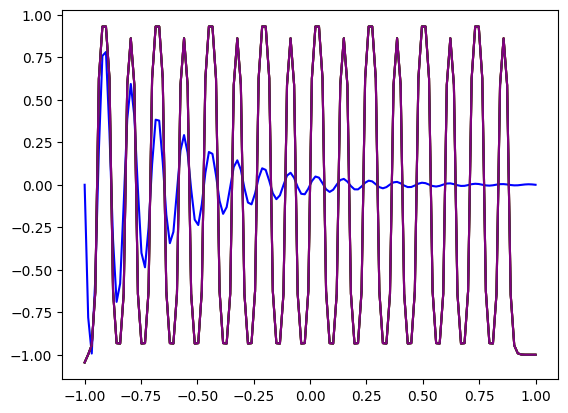

In [ ]:
l=generate_dataset_ood(1,0.01,x_grid,t_eval,'exp')
plt.plot(x_grid,l[0,0,:], color='blue')
plt.plot(x_grid,l[0,1,:], color='red')
plt.plot(x_grid,l[0,2,:], color='black')
plt.plot(x_grid,l[0,3,:], color='green')
plt.plot(x_grid,l[0,4,:], color= 'purple')